In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('fifa').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 13:54:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.csv('fifa_players.csv', header=True, inferSchema=True)

In [3]:
df.show()

24/05/23 13:54:56 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------------+--------------------+----------+---+---------+----------+-----------+--------------+---------+----------+---------+--------------+-----------------------------+--------------+----------------+---------+-------------------+-------------+---------------+----------------------+----------------------+--------+---------+----------------+-------------+-------+---------+-----+-----------------+------------+------------+------------+------------+-------+---------+-------+----------+-------+-------+--------+----------+----------+-------------+-----------+------+---------+---------+-------+---------------+--------------+
|           name|           full_name|birth_date|age|height_cm|weight_kgs|nationality|overall_rating|potential|value_euro|wage_euro|preferred_foot|international_reputation(1-5)|weak_foot(1-5)|skill_moves(1-5)|body_type|release_clause_euro|national_team|national_rating|national_team_position|national_jersey_number|crossing|finishing|heading_accuracy|short_passing

In [4]:
df.show(10)

+------------+--------------------+----------+---+---------+----------+-----------+--------------+---------+----------+---------+--------------+-----------------------------+--------------+----------------+---------+-------------------+-------------+---------------+----------------------+----------------------+--------+---------+----------------+-------------+-------+---------+-----+-----------------+------------+------------+------------+------------+-------+---------+-------+----------+-------+-------+--------+----------+----------+-------------+-----------+------+---------+---------+-------+---------------+--------------+
|        name|           full_name|birth_date|age|height_cm|weight_kgs|nationality|overall_rating|potential|value_euro|wage_euro|preferred_foot|international_reputation(1-5)|weak_foot(1-5)|skill_moves(1-5)|body_type|release_clause_euro|national_team|national_rating|national_team_position|national_jersey_number|crossing|finishing|heading_accuracy|short_passing|volle

In [5]:
df.select("name", "full_name", "birth_date", "age", "height_cm", "weight_kgs").show(10)

+------------+--------------------+----------+---+---------+----------+
|        name|           full_name|birth_date|age|height_cm|weight_kgs|
+------------+--------------------+----------+---+---------+----------+
|    L. Messi|Lionel Andrés Mes...| 6/24/1987| 31|   170.18|      72.1|
|  C. Eriksen|Christian  Dannem...| 2/14/1992| 27|   154.94|      76.2|
|    P. Pogba|          Paul Pogba| 3/15/1993| 25|    190.5|      83.9|
|  L. Insigne|     Lorenzo Insigne|  6/4/1991| 27|   162.56|      59.0|
|K. Koulibaly|   Kalidou Koulibaly| 6/20/1991| 27|   187.96|      88.9|
| V. van Dijk|     Virgil van Dijk|  7/8/1991| 27|   193.04|      92.1|
|   K. Mbappé|       Kylian Mbappé|12/20/1998|120|    152.4|      73.0|
|   S. Agüero|Sergio Leonel Agü...|  6/2/1988| 30|   172.72|      69.9|
|    M. Neuer|        Manuel Neuer| 3/27/1986| 32|   193.04|      92.1|
|   E. Cavani|Edinson Roberto C...| 2/14/1987| 32|   185.42|      77.1|
+------------+--------------------+----------+---+---------+----

In [6]:
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- full_name: string (nullable = true)
 |-- birth_date: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- height_cm: double (nullable = true)
 |-- weight_kgs: double (nullable = true)
 |-- nationality: string (nullable = true)
 |-- overall_rating: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_euro: integer (nullable = true)
 |-- wage_euro: integer (nullable = true)
 |-- preferred_foot: string (nullable = true)
 |-- international_reputation(1-5): integer (nullable = true)
 |-- weak_foot(1-5): integer (nullable = true)
 |-- skill_moves(1-5): integer (nullable = true)
 |-- body_type: string (nullable = true)
 |-- release_clause_euro: integer (nullable = true)
 |-- national_team: string (nullable = true)
 |-- national_rating: integer (nullable = true)
 |-- national_team_position: string (nullable = true)
 |-- national_jersey_number: integer (nullable = true)
 |-- crossing: integer (nullable = true)


In [7]:
from pyspark.sql.functions import format_number, col, round, mean

In [8]:
# get initial summary_dataframe
summary_df = df.select("age", "height_cm", "weight_kgs", "value_euro").summary()

# formatting the number value cols
formatted_summary_df = summary_df.select(
    col("summary"),
    round(col("age"), 2).alias("age"),
    round(col("height_cm"), 2).alias("height_cm"),
    round(col("weight_kgs"), 2).alias("weight_kgs"),
    round(col("value_euro"), 2).alias("value_euro")
)

# show the formatted summary DataFrame
formatted_summary_df.show()


+-------+-------+---------+----------+----------+
|summary|    age|height_cm|weight_kgs|value_euro|
+-------+-------+---------+----------+----------+
|  count|17203.0|  17203.0|   17203.0|   16949.0|
|   mean|  26.56|   174.97|     75.37|2527889.55|
| stddev|   12.3|    14.04|      7.09| 5685210.6|
|    min|  -30.0|    152.4|      49.9|   10000.0|
|    25%|   22.0|   154.94|      69.9|  325000.0|
|    50%|   25.0|   175.26|      74.8|  725000.0|
|    75%|   29.0|   185.42|      79.8| 2200000.0|
|    max|  129.0|   205.74|     107.0|   1.105E8|
+-------+-------+---------+----------+----------+



In [9]:
# This cell is for showing the correlation between selected fields and target field
fields = ["age", "height_cm", "weight_kgs", "value_euro"]

# calculate the corr matrix
correlation_matrix = []
for field1 in fields:
    correlation_row = []
    for field2 in fields:
        corr_value = df.stat.corr(field1, field2)
        correlation_row.append(corr_value)
    correlation_matrix.append(correlation_row)

# transform the martrix to dataframe
correlation_df = spark.createDataFrame(correlation_matrix, schema=fields)
correlation_df = correlation_df.withColumn("field", col("age")).select("field", *fields)

# show the dataframe
correlation_df.show()

+-------------------+-------------------+-------------------+-------------------+--------------------+
|              field|                age|          height_cm|         weight_kgs|          value_euro|
+-------------------+-------------------+-------------------+-------------------+--------------------+
|                1.0|                1.0|0.02880137083261802| 0.1073928428918498|  0.2959419853695831|
|0.02880137083261802|0.02880137083261802|                1.0|0.49577832537441924|0.008880323496398173|
|0.10739284289184982|0.10739284289184982| 0.4957783253744194|                1.0| 0.04154688540925685|
| 0.2959419853695831| 0.2959419853695831|0.00888032349639817|0.04154688540925682|                 1.0|
+-------------------+-------------------+-------------------+-------------------+--------------------+



In [10]:
# select age and value_euro as a new dataframe, which is ordered by body_type
df_order = (
    df.select("body_type", "value_euro")
    .groupBy("body_type")
    .mean("value_euro")
    .withColumnRenamed("avg(value_euro)", "value_euro")
    .withColumn("value_euro", round(col("value_euro"), 2))
    .orderBy("body_type")
)

df_order.show()

+---------+----------+
|body_type|value_euro|
+---------+----------+
|     Lean| 2578519.0|
|   Normal|2481078.46|
|   Stocky|2671331.42|
+---------+----------+



In [11]:
from pyspark.sql.functions import sum, when, expr
import pandas as pd

In [12]:
# calculate the number of null values in each cols
null_counts = df.agg(*[sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns])

# convert pySpark DataFrame to pandas DataFrame
null_counts_pd = null_counts.toPandas()

# improve the readability
null_counts_transposed = null_counts_pd.transpose().reset_index()
null_counts_transposed.columns = ["Column", "Null Count"]

print(null_counts_transposed)

                           Column  Null Count
0                            name           0
1                       full_name           0
2                      birth_date           0
3                             age           0
4                       height_cm           0
5                      weight_kgs           0
6                     nationality           0
7                  overall_rating           0
8                       potential           0
9                      value_euro         254
10                      wage_euro         245
11                 preferred_foot           0
12  international_reputation(1-5)           0
13                 weak_foot(1-5)           0
14               skill_moves(1-5)           0
15                      body_type           0
16            release_clause_euro        1787
17                  national_team       16370
18                national_rating       16369
19         national_team_position       16369
20         national_jersey_number 

In [13]:
# calclulate quantile
value_high = df.approxQuantile("value_euro", [0.999], 0.01)[0]
value_low = df.approxQuantile("value_euro", [0.001], 0.01)[0]

# calculate mean value
value_mean = df.select(mean("value_euro")).collect()[0][0]

print(f"0.999 quantile: {value_high}")
print(f"0.001 quantile: {value_low}")
print(f"Mean: {value_mean}")

0.999 quantile: 110500000.0
0.001 quantile: 10000.0
Mean: 2527889.551005959


In [14]:
df = df.filter((df['value_euro'] < 110500000) &( df['value_euro'] > 10000))

In [15]:
# get initial summary_dataframe
summary_df = df.select("age", "height_cm", "weight_kgs", "value_euro").summary()

# formatting the number value cols
formatted_summary_df = summary_df.select(
    col("summary"),
    round(col("age"), 2).alias("age"),
    round(col("height_cm"), 2).alias("height_cm"),
    round(col("weight_kgs"), 2).alias("weight_kgs"),
    round(col("value_euro"), 2).alias("value_euro")
)

# show the formatted summary DataFrame
formatted_summary_df.show()


+-------+-------+---------+----------+----------+
|summary|    age|height_cm|weight_kgs|value_euro|
+-------+-------+---------+----------+----------+
|  count|16935.0|  16935.0|   16935.0|   16935.0|
|   mean|  26.53|   174.95|     75.35|2523446.71|
| stddev|  12.36|    14.04|      7.09|5626279.26|
|    min|  -30.0|    152.4|      49.9|   20000.0|
|    25%|   22.0|   154.94|      69.9|  325000.0|
|    50%|   25.0|   175.26|      74.8|  725000.0|
|    75%|   29.0|   185.42|      79.8| 2200000.0|
|    max|  129.0|   205.74|     107.0|    1.08E8|
+-------+-------+---------+----------+----------+



In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

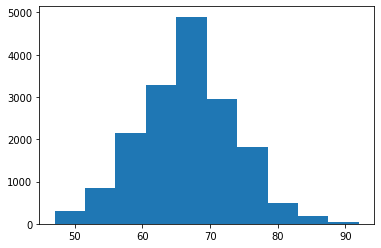

In [17]:
ratingArr = np.array(df.select('overall_rating').collect())
plt.hist(ratingArr)
plt.show()

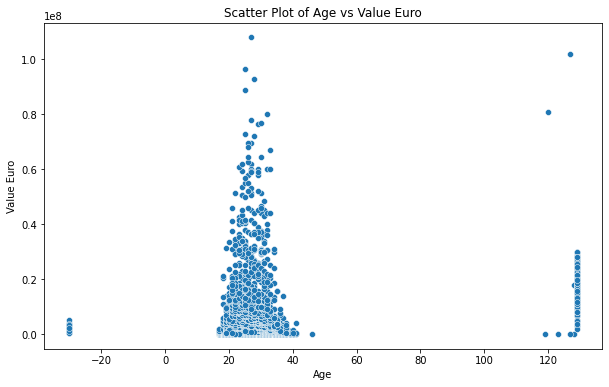

In [18]:
# select fields
ageFields = ["age", "value_euro"]

# convert pyspark df to pandas df
pandas_df = df.select(ageFields).toPandas()

# draw cratter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pandas_df, x="age", y="value_euro")
plt.title("Scatter Plot of Age vs Value Euro")
plt.xlabel("Age")
plt.ylabel("Value Euro")
plt.show()

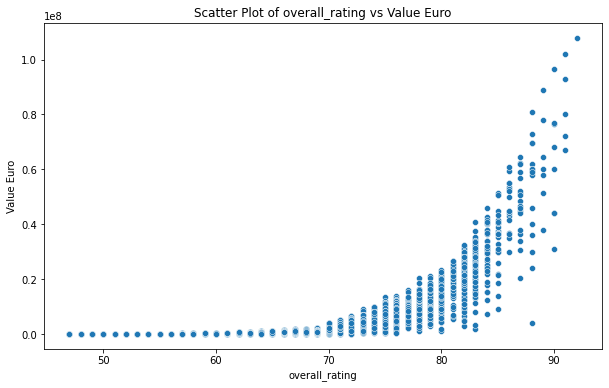

In [19]:
# select fields
ratingFields = ["overall_rating", "value_euro"]

# convert pyspark df to pandas df
pandas_df = df.select(ratingFields).toPandas()

# draw cratter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pandas_df, x="overall_rating", y="value_euro")
plt.title("Scatter Plot of overall_rating vs Value Euro")
plt.xlabel("overall_rating")
plt.ylabel("Value Euro")
plt.show()

In [20]:
df = df.filter((df['age'] > 0) &( df['age'] < 80))
# get initial summary_dataframe
summary_df = df.select("age", "height_cm", "weight_kgs", "value_euro").summary()

# formatting the number value cols
formatted_summary_df = summary_df.select(
    col("summary"),
    round(col("age"), 2).alias("age"),
    round(col("height_cm"), 2).alias("height_cm"),
    round(col("weight_kgs"), 2).alias("weight_kgs"),
    round(col("value_euro"), 2).alias("value_euro")
)

# show the formatted summary DataFrame
formatted_summary_df.show()

+-------+-------+---------+----------+----------+
|summary|    age|height_cm|weight_kgs|value_euro|
+-------+-------+---------+----------+----------+
|  count|16696.0|  16696.0|   16696.0|   16696.0|
|   mean|  25.46|   174.93|     75.33| 2337728.5|
| stddev|   4.71|    14.04|      7.08|5298463.67|
|    min|   17.0|    152.4|      49.9|   20000.0|
|    25%|   22.0|   154.94|      69.9|  325000.0|
|    50%|   25.0|   175.26|      74.8|  700000.0|
|    75%|   29.0|   185.42|      79.8| 2100000.0|
|    max|   46.0|   205.74|     107.0|    1.08E8|
+-------+-------+---------+----------+----------+



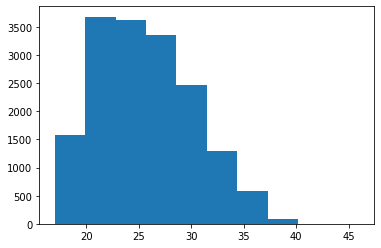

In [21]:
ageArr = np.array(df.select('age').collect())
plt.hist(ageArr)
plt.show()

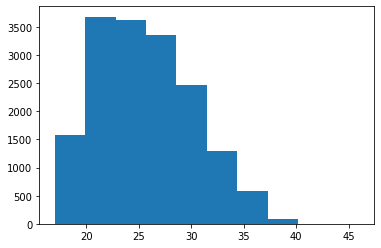

In [22]:
ageArr = np.array(df.select('age').collect())
plt.hist(ageArr)
plt.show()

In [23]:
df = df.drop("full_name","nationality","national_jursey_number","national_team_position","national_team","national_rating")
df = df.na.drop()

# calculate the number of null values in each cols
null_counts = df.agg(*[sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns])

# convert pySpark DataFrame to pandas DataFrame
null_counts_pd = null_counts.toPandas()

# improve the readability
null_counts_transposed = null_counts_pd.transpose().reset_index()
null_counts_transposed.columns = ["Column", "Null Count"]

print(null_counts_transposed)

                           Column  Null Count
0                            name           0
1                      birth_date           0
2                             age           0
3                       height_cm           0
4                      weight_kgs           0
5                  overall_rating           0
6                       potential           0
7                      value_euro           0
8                       wage_euro           0
9                  preferred_foot           0
10  international_reputation(1-5)           0
11                 weak_foot(1-5)           0
12               skill_moves(1-5)           0
13                      body_type           0
14            release_clause_euro           0
15         national_jersey_number           0
16                       crossing           0
17                      finishing           0
18               heading_accuracy           0
19                  short_passing           0
20                        volleys 

In [24]:
df = df.withColumn(
    'age_tier',
    when(col('age') <= 25, 'Young')
    .when((col('age') > 25) & (col('age') <= 35), 'Matured_young')
    .otherwise('Middle_age')
)

df.select('age_tier').show()

+-------------+
|     age_tier|
+-------------+
|Matured_young|
|        Young|
|Matured_young|
|Matured_young|
|Matured_young|
|Matured_young|
|Matured_young|
|Matured_young|
|Matured_young|
|Matured_young|
|        Young|
|Matured_young|
|Matured_young|
|Matured_young|
|Matured_young|
|Matured_young|
|Matured_young|
|Matured_young|
|Matured_young|
|        Young|
+-------------+
only showing top 20 rows



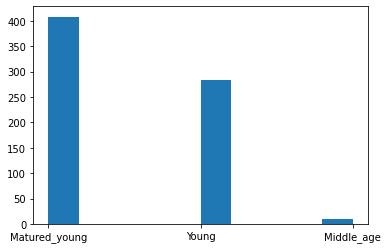

In [25]:
agetierArr = np.array(df.select('age_tier').collect())
plt.hist(agetierArr)
plt.show()

In [26]:
# create new col according to the mean value of selected clos
df = df.withColumn('attack', (col('finishing') + col('heading_accuracy') + col('volleys') +
                              col('freekick_accuracy') + col('shot_power') + col('long_shots') +
                              col('aggression') + col('penalties') + col('composure')) / 9)

df = df.withColumn('passing', (col('crossing') + col('short_passing') + col('long_passing') +
                               col('vision')) / 4)

df = df.withColumn('physical_quality', (col('acceleration') + col('sprint_speed') + col('reactions') +
                                        col('balance') + col('jumping') + col('stamina') +
                                        col('strength')) / 7)

df = df.withColumn('ball_control', (col('dribbling') + col('ball_control') + col('agility')) / 3)

df = df.withColumn('defending', (col('interceptions') + col('positioning') + col('marking') +
                                 col('standing_tackle') + col('sliding_tackle')) / 5)

In [27]:
df.select('attack','passing','physical_quality','ball_control','defending').show()

+------------------+-------+------------------+------------------+---------+
|            attack|passing|  physical_quality|      ball_control|defending|
+------------------+-------+------------------+------------------+---------+
| 74.88888888888889|  89.75|              74.0|              85.0|     55.6|
| 81.77777777777777|   86.0| 79.42857142857143| 84.33333333333333|     68.6|
|              69.0|   84.0| 75.42857142857143| 92.33333333333333|     41.2|
| 69.55555555555556|  68.25| 77.42857142857143|              69.0|     78.4|
| 81.88888888888889|   74.5| 82.71428571428571|              88.0|     35.6|
|27.444444444444443|  49.75|61.857142857142854|42.333333333333336|     16.0|
| 84.55555555555556|  69.25| 79.85714285714286| 79.66666666666667|     55.4|
| 66.66666666666667|   80.0| 67.14285714285714|              78.0|     84.0|
|24.555555555555557|  44.25| 58.42857142857143|              24.0|     16.2|
| 83.66666666666667|  82.25| 83.28571428571429|              89.0|     60.2|

In [28]:
# calculate the correlation of these new features
fields = ['attack', 'passing', 'physical_quality', 'ball_control', 'defending', 'value_euro']

correlation_matrix = []
for field1 in fields:
    correlation_row = []
    for field2 in fields:
        corr_value = df.stat.corr(field1, field2)
        correlation_row.append(corr_value)
    correlation_matrix.append(correlation_row)

correlation_df = pd.DataFrame(correlation_matrix, columns=fields, index=fields)
print(correlation_df)

                    attack   passing  physical_quality  ball_control  \
attack            1.000000  0.878041          0.779497      0.894052   
passing           0.878041  1.000000          0.770129      0.904978   
physical_quality  0.779497  0.770129          1.000000      0.851411   
ball_control      0.894052  0.904978          0.851411      1.000000   
defending         0.556289  0.669188          0.597174      0.540696   
value_euro        0.325928  0.349942          0.321386      0.292793   

                  defending  value_euro  
attack             0.556289    0.325928  
passing            0.669188    0.349942  
physical_quality   0.597174    0.321386  
ball_control       0.540696    0.292793  
defending          1.000000    0.085335  
value_euro         0.085335    1.000000  


In [29]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors, DenseVector
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer, PCA, ChiSqSelector
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.stat import Correlation

In [30]:
assembler = VectorAssembler(
    inputCols=["attack", "passing", 
               "physical_quality","ball_control","defending","age","height_cm","weight_kgs"],
    outputCol="features")

In [31]:
output = assembler.transform(df)

In [32]:
output.printSchema()
output.head(1)

root
 |-- name: string (nullable = true)
 |-- birth_date: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- height_cm: double (nullable = true)
 |-- weight_kgs: double (nullable = true)
 |-- overall_rating: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_euro: integer (nullable = true)
 |-- wage_euro: integer (nullable = true)
 |-- preferred_foot: string (nullable = true)
 |-- international_reputation(1-5): integer (nullable = true)
 |-- weak_foot(1-5): integer (nullable = true)
 |-- skill_moves(1-5): integer (nullable = true)
 |-- body_type: string (nullable = true)
 |-- release_clause_euro: integer (nullable = true)
 |-- national_jersey_number: integer (nullable = true)
 |-- crossing: integer (nullable = true)
 |-- finishing: integer (nullable = true)
 |-- heading_accuracy: integer (nullable = true)
 |-- short_passing: integer (nullable = true)
 |-- volleys: integer (nullable = true)
 |-- dribbling: integer (nullable = true)
 |-- curve: 

[Row(name='C. Eriksen', birth_date='2/14/1992', age=27, height_cm=154.94, weight_kgs=76.2, overall_rating=88, potential=89, value_euro=69500000, wage_euro=205000, preferred_foot='Right', international_reputation(1-5)=3, weak_foot(1-5)=5, skill_moves(1-5)=4, body_type='Lean', release_clause_euro=133800000, national_jersey_number=10, crossing=88, finishing=81, heading_accuracy=52, short_passing=91, volleys=80, dribbling=84, curve=86, freekick_accuracy=87, long_passing=89, ball_control=85.0, acceleration=76, sprint_speed=73, agility=80, reactions=88, balance=81, shot_power=84, jumping=50, stamina=92, strength=58, long_shots=89, aggression=46, interceptions=56, positioning=84, vision=91, penalties=67, composure=88, marking=59, standing_tackle=57, sliding_tackle=22, age_tier='Matured_young', attack=74.88888888888889, passing=89.75, physical_quality=74.0, defending=55.6, features=DenseVector([74.8889, 89.75, 74.0, 85.0, 55.6, 27.0, 154.94, 76.2]))]

In [33]:
final_data = output.select("features",'value_euro')
final_data.show()

+--------------------+----------+
|            features|value_euro|
+--------------------+----------+
|[74.8888888888888...|  69500000|
|[81.7777777777777...|  73000000|
|[69.0,84.0,75.428...|  62000000|
|[69.5555555555555...|  59500000|
|[81.8888888888888...|  64500000|
|[27.4444444444444...|  38000000|
|[84.5555555555555...|  60000000|
|[66.6666666666666...|  51500000|
|[24.5555555555555...|  58000000|
|[83.6666666666666...|  78000000|
|[79.5555555555555...|  89000000|
|[71.1111111111111...|  34000000|
|[72.2222222222222...|  45000000|
|[66.6666666666666...|  44000000|
|[68.2222222222222...|  38000000|
|[73.4444444444444...|  51500000|
|[79.0,60.75,78.0,...|  52000000|
|[72.1111111111111...|  62500000|
|[76.5555555555555...|  64500000|
|[23.2222222222222...|  31000000|
+--------------------+----------+
only showing top 20 rows



In [34]:
train_data,test_data = final_data.randomSplit([0.8,0.2])

In [35]:
train_data.describe().show()

test_data.describe().show()

+-------+--------------------+
|summary|          value_euro|
+-------+--------------------+
|  count|                 555|
|   mean|1.1288531531531531E7|
| stddev|1.5146170381220603E7|
|    min|              240000|
|    max|            96500000|
+-------+--------------------+

+-------+--------------------+
|summary|          value_euro|
+-------+--------------------+
|  count|                 145|
|   mean|1.3877379310344828E7|
| stddev|1.7623208932662945E7|
|    min|              220000|
|    max|           108000000|
+-------+--------------------+



In [36]:
lr = LinearRegression(labelCol='value_euro')

In [37]:
r1 = lr.fit(train_data)

24/05/23 13:55:43 WARN Instrumentation: [3de155ad] regParam is zero, which might cause numerical instability and overfitting.
24/05/23 13:55:44 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/23 13:55:44 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
24/05/23 13:55:44 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [38]:
print("Coefficients: {} Intercept: {}".format(r1.coefficients,r1.intercept))

Coefficients: [44817.71491402853,861074.6582587569,1031332.982000142,-545313.8161534021,-347184.3439577721,-176642.8519593128,171913.37233013514,325304.16215724073] Intercept: -112597778.17607722


In [39]:
test_results = r1.evaluate(test_data)

In [40]:
test_results.residuals.show()

print("RSME: {}".format(test_results.rootMeanSquaredError))

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+--------------------+
|           residuals|
+--------------------+
|1.3541941949437365E7|
| 1.693511978980747E7|
|   8157823.104149088|
|  -2271780.723725468|
| 2.087624315938452E7|
|1.0004992623908669E7|
|1.0450524226102054E7|
| -155714.36880996823|
|1.2871068683627903E7|
| -4510312.9400114715|
|   7085455.176347107|
|   7810438.671514377|
|   8438452.551853895|
| -1800278.2299635857|
|  -7762971.001552239|
|2.3551358231694818E7|
| -2484502.2401013523|
|   2416605.691911027|
|5.6537165486500695E7|
|-1.03581847102204...|
+--------------------+
only showing top 20 rows

RSME: 15781804.338790486


In [41]:
print("R2: {}".format(test_results.r2))

R2: 0.19248827025167903


In [42]:
# feature engineering
string_indexer = StringIndexer(inputCol="age_tier", outputCol="age_tier_index")
onehot_encoder = OneHotEncoder(inputCol="age_tier_index", outputCol="age_tier_ohe")

In [43]:
# select features
feature_columns = ['attack', 'passing', 'physical_quality', 'ball_control', 'defending', 'overall_rating', 'age_tier_ohe']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [44]:
lr = LinearRegression(featuresCol='features', labelCol='value_euro')

In [45]:
pipeline = Pipeline(stages=[string_indexer, onehot_encoder, assembler, lr])

In [46]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [47]:
r2 = pipeline.fit(train_data)

24/05/23 13:55:49 WARN Instrumentation: [859a92ba] regParam is zero, which might cause numerical instability and overfitting.


In [48]:
predictions = r2.transform(test_data)

In [49]:
# evaluating
evaluator = RegressionEvaluator(labelCol="value_euro", predictionCol="prediction", metricName="r2")
r_squared = evaluator.evaluate(predictions)

print(f"R^2 on test data = {r_squared}")

R^2 on test data = 0.7192324867526704


In [50]:
# r3
# apply PCA
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pipeline = Pipeline(stages=[string_indexer, onehot_encoder, assembler, pca])
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_data)
transformed_data = model.transform(test_data)

# extract PCA result
projected_data = transformed_data.select("pca_features", "value_euro")

# LR with PCA
lr = LinearRegression(featuresCol='pca_features', labelCol='value_euro')

# training LR model
r3 = lr.fit(projected_data)

# predicting
predictions = r3.transform(projected_data)

# estimating model
evaluator = RegressionEvaluator(labelCol="value_euro", predictionCol="prediction", metricName="r2")
r_squared = evaluator.evaluate(predictions)

print(f"R^2 on test data = {r_squared}")

24/05/23 13:55:55 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/05/23 13:55:55 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
24/05/23 13:55:56 WARN Instrumentation: [f3ff649b] regParam is zero, which might cause numerical instability and overfitting.


R^2 on test data = 0.09509139087822793


In [51]:
pipeline = Pipeline(stages=[string_indexer, onehot_encoder, assembler])
transformed_data = model.transform(train_data)
lr = LinearRegression(featuresCol='features', labelCol='value_euro')
lr_model = lr.fit(transformed_data)

# extract the importance of features
feature_importances = lr_model.coefficients.toArray()

# select top 5 important features
k = 5
top_k_features_indices = feature_importances.argsort()[-k:][::-1]
print(top_k_features_indices)
print(feature_columns)

24/05/23 13:55:58 WARN Instrumentation: [566bff49] regParam is zero, which might cause numerical instability and overfitting.


[7 6 5 3 0]
['attack', 'passing', 'physical_quality', 'ball_control', 'defending', 'overall_rating', 'age_tier_ohe']


In [52]:
# r4
string_indexer = StringIndexer(inputCol="age_tier", outputCol="age_tier_index")
onehot_encoder = OneHotEncoder(inputCol="age_tier_index", outputCol="age_tier_ohe")

feature_columns = ['age_tier_ohe', 'overall_rating', 'defending', 'physical_quality', 'attack']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

pipeline = Pipeline(stages=[string_indexer, onehot_encoder, assembler])

train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

pipeline_model = pipeline.fit(train_data)
train_transformed = pipeline_model.transform(train_data)
test_transformed = pipeline_model.transform(test_data)

lr = LinearRegression(featuresCol='features', labelCol='value_euro')

r4 = lr.fit(train_transformed)

predictions = r4.transform(test_transformed)

evaluator = RegressionEvaluator(labelCol="value_euro", predictionCol="prediction", metricName="r2")
evaluator = RegressionEvaluator(labelCol="value_euro", predictionCol="prediction", metricName="r2")
r_squared = evaluator.evaluate(predictions)
print(f"R^2 on test data = {r_squared}")

24/05/23 13:56:01 WARN Instrumentation: [377ef62b] regParam is zero, which might cause numerical instability and overfitting.


R^2 on test data = 0.7210372582948545


In [53]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

24/05/23 13:56:03 WARN Instrumentation: [3e94af69] regParam is zero, which might cause numerical instability and overfitting.


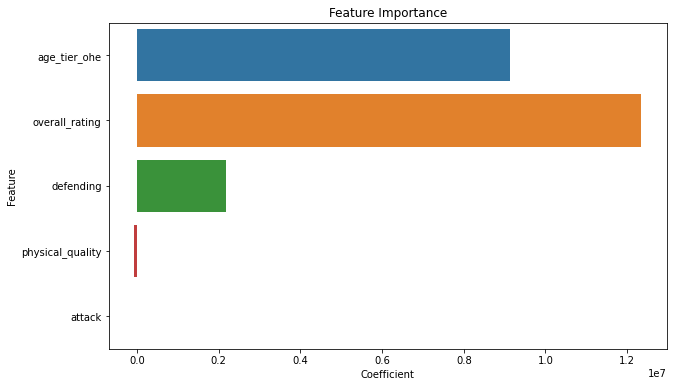

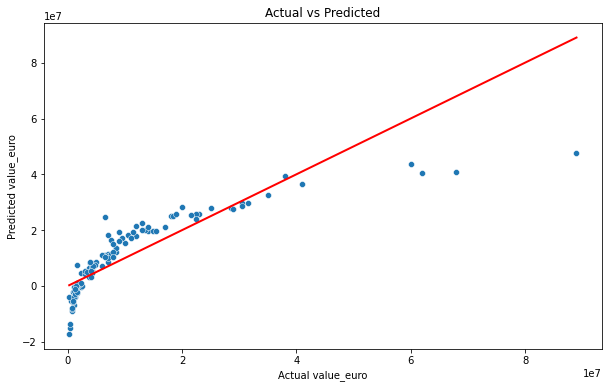

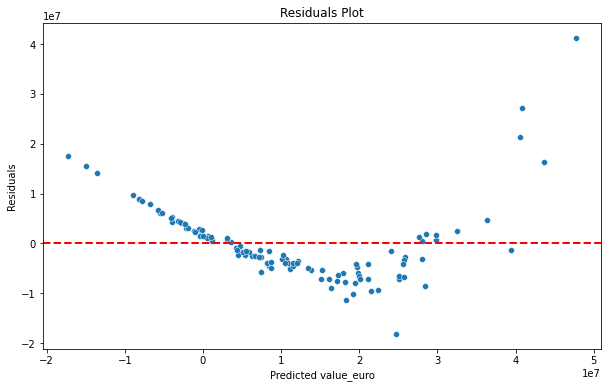

In [54]:
lr = LinearRegression(featuresCol='features', labelCol='value_euro')

# model training
lr_model = lr.fit(train_transformed)

# predict
predictions = lr_model.transform(test_transformed)

# convert to Pandas dataframe
predictions_pd = predictions.select("value_euro", "prediction").toPandas()

# feature importance visualization
coefficients = lr_model.coefficients.toArray()
intercept = lr_model.intercept
feature_importance = pd.DataFrame(list(zip(feature_columns, coefficients)), columns=["Feature", "Coefficient"])
plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=feature_importance)
plt.title("Feature Importance")
plt.show()

# scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x="value_euro", y="prediction", data=predictions_pd)
plt.plot([predictions_pd["value_euro"].min(), predictions_pd["value_euro"].max()],
         [predictions_pd["value_euro"].min(), predictions_pd["value_euro"].max()], color='red', lw=2)
plt.title("Actual vs Predicted")
plt.xlabel("Actual value_euro")
plt.ylabel("Predicted value_euro")
plt.show()

# residuals
predictions_pd["residuals"] = predictions_pd["value_euro"] - predictions_pd["prediction"]
plt.figure(figsize=(10, 6))
sns.scatterplot(x="prediction", y="residuals", data=predictions_pd)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.title("Residuals Plot")
plt.xlabel("Predicted value_euro")
plt.ylabel("Residuals")
plt.show()


In [94]:

train_data, test_data = df.randomSplit([0.9, 0.1], seed=42)

pipeline_model = pipeline.fit(train_data)
train_transformed = pipeline_model.transform(train_data)
test_transformed = pipeline_model.transform(test_data)

lr = LinearRegression(featuresCol='features', labelCol='value_euro')

r4 = lr.fit(train_transformed)

predictions = r4.transform(test_transformed)

evaluator = RegressionEvaluator(labelCol="value_euro", predictionCol="prediction", metricName="r2")
evaluator = RegressionEvaluator(labelCol="value_euro", predictionCol="prediction", metricName="r2")
r_squared = evaluator.evaluate(predictions)
print(f"R^2 on test data = {r_squared}")

24/05/23 14:10:55 WARN Instrumentation: [bcacbba0] regParam is zero, which might cause numerical instability and overfitting.


R^2 on test data = 0.7092845168429264
